## Question 2 - A (Predictive Model based on Accuracy)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
import numpy as np
import pandas as pd

# Define models and hyperparameters
models = {
    'kNN': (
        KNeighborsClassifier(), 
        {'n_neighbors': [3, 5, 7]}
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42), 
        {'max_depth': [5, 10, None]}
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=1000), 
        {'C': [0.1, 1, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42), 
        {'n_estimators': [50, 100], 'max_depth': [10, None]}
    ),
    'Neural Network': (
        MLPClassifier(max_iter=1000, random_state=42), 
        {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
    ),
    'SVM': (
        SVC(probability=True), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
}

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = {}

for name, (model, param_grid) in models.items():
    print(f"Running nested CV for: {name}")
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        refit=True,
        n_jobs=-1
    )
    
    nested_scores = cross_validate(
        estimator=clf,
        X=X_train_val,
        y=y_train_val,
        cv=outer_cv,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        return_estimator=True,
        n_jobs=-1
    )
    
    results[name] = nested_scores
    
    print(f"{name} → "
          f"Accuracy: {np.mean(nested_scores['test_accuracy']):.4f}, "
          f"Precision: {np.mean(nested_scores['test_precision']):.4f}, "
          f"Recall: {np.mean(nested_scores['test_recall']):.4f}, "
          f"F1: {np.mean(nested_scores['test_f1']):.4f}, "
          f"AUC: {np.mean(nested_scores['test_roc_auc']):.4f}")

# Summary as a DataFrame
summary_df = pd.DataFrame({
    model: {
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1': np.mean(scores['test_f1']),
        'AUC': np.mean(scores['test_roc_auc'])
    }
    for model, scores in results.items()
}).T

print("\nSummary of All Models (Nested CV Mean Scores):")
print(summary_df.round(4))

Running nested CV for: kNN
kNN → Accuracy: 0.9082, Precision: 0.9000, Recall: 0.8634, F1: 0.8811, AUC: 0.9484
Running nested CV for: Decision Tree
Decision Tree → Accuracy: 0.9209, Precision: 0.9318, Recall: 0.8634, F1: 0.8956, AUC: 0.9161
Running nested CV for: Logistic Regression
Logistic Regression → Accuracy: 0.9250, Precision: 0.9198, Recall: 0.8876, F1: 0.9032, AUC: 0.9709
Running nested CV for: Random Forest
Random Forest → Accuracy: 0.9516, Precision: 0.9504, Recall: 0.9255, F1: 0.9378, AUC: 0.9853
Running nested CV for: Neural Network
Neural Network → Accuracy: 0.9443, Precision: 0.9315, Recall: 0.9269, F1: 0.9292, AUC: 0.9757
Running nested CV for: SVM
SVM → Accuracy: 0.9307, Precision: 0.9260, Recall: 0.8959, F1: 0.9106, AUC: 0.9741

Summary of All Models (Nested CV Mean Scores):
                     Accuracy  Precision  Recall      F1     AUC
kNN                    0.9082     0.9000  0.8634  0.8811  0.9484
Decision Tree          0.9209     0.9318  0.8634  0.8956  0.9161
Log

In [57]:
# Weighted score for overall model performance
weights = {
    'Accuracy': 0.4,
    'Precision': 0.2,
    'Recall': 0.2,
    'F1': 0.1,
    'AUC': 0.1
}

summary_df['WeightedScore'] = sum(summary_df[metric] * weight for metric, weight in weights.items())
best_by_weighted = summary_df['WeightedScore'].idxmax()

print(f"Best model based on Weighted Score: {best_by_weighted}")
print(summary_df.loc[best_by_weighted])

Best model based on Weighted Score: Random Forest
Accuracy         0.951630
Precision        0.950415
Recall           0.925517
F1               0.937752
AUC              0.985296
WeightedScore    0.948143
Name: Random Forest, dtype: float64


###  Best Model: Random Forest

The **Random Forest** model was selected as the best performer based on nested cross-validation results. It achieved the highest scores across key metrics:

- **Accuracy**: 95.16%
- **F1 Score**: 93.78%
- **Recall**: 92.55%
- **AUC**: 98.53%

This indicates strong overall predictive power and a good balance between false positives and false negatives, making it the most reliable model for spam detection.

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[540  18]
 [ 32 331]]
Accuracy: 0.9457111834961998
Precision: 0.9484240687679083
Recall: 0.9118457300275482
F1 Score: 0.9297752808988764
AUC: 0.9833772722335773


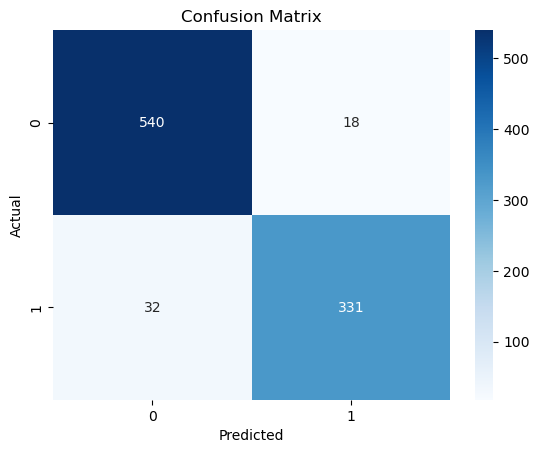

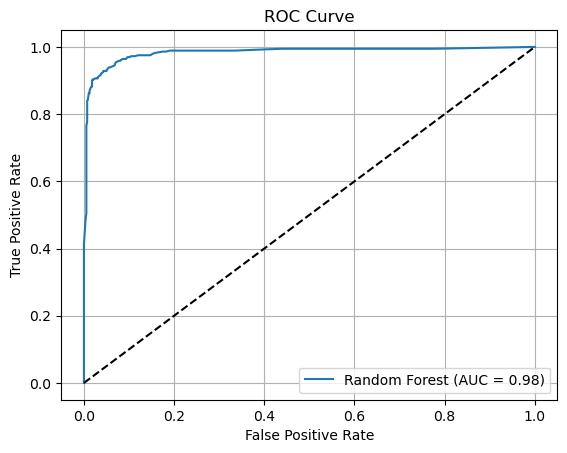

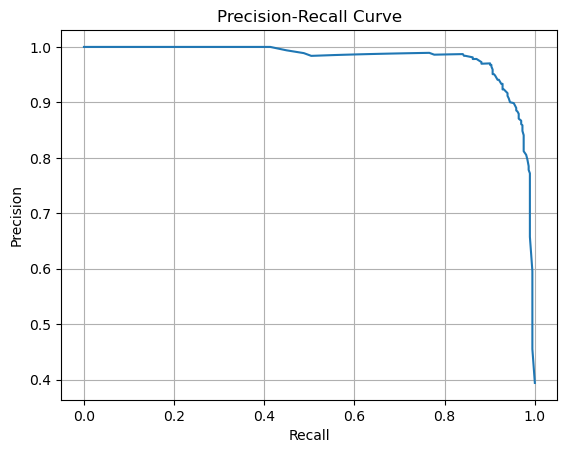

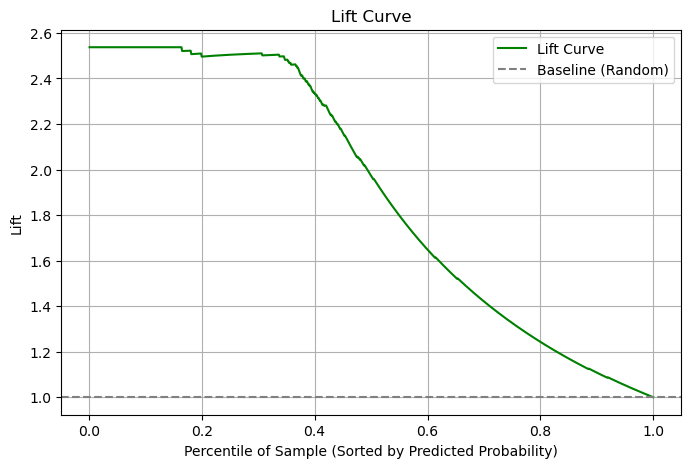

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Lift Chart (Precision-Recall)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

# Sort test instances by predicted probability (descending)
sorted_indices = np.argsort(y_proba)[::-1]
sorted_probs = y_proba[sorted_indices]
sorted_true = np.array(y_test)[sorted_indices]  # convert to array for indexing if needed

# Cumulative true positive rate
cumulative_true_positive_rate = np.cumsum(sorted_true) / np.sum(sorted_true)

# Cumulative percentage of total samples
cumulative_percentile = np.arange(1, len(sorted_true) + 1) / len(sorted_true)

# Lift = how much better we're doing compared to random selection
lift = cumulative_true_positive_rate / cumulative_percentile

# Plot the Lift Curve
plt.figure(figsize=(8, 5))
plt.plot(cumulative_percentile, lift, label='Lift Curve', color='green')
plt.axhline(y=1, color='gray', linestyle='--', label='Baseline (Random)')
plt.xlabel('Percentile of Sample (Sorted by Predicted Probability)')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.grid(True)
plt.legend()
plt.show()


###  Model Summary: Random Forest Classifier

The **Random Forest** model was selected as the best performer for spam detection based on high scores across all key evaluation metrics.

- **Confusion Matrix**:  
  - True Negatives: 540  
  - False Positives: 18  
  - False Negatives: 32  
  - True Positives: 331  

- **ROC Curve**: AUC = **0.98**, indicating excellent separability between spam and non-spam emails.

- **Precision-Recall Curve**: Maintains high precision across most recall values, showing robustness in identifying spam.

- **Lift Curve**: Demonstrates strong lift, especially in the top deciles, indicating effective ranking of high-risk emails.

Overall, Random Forest delivers a strong balance between precision and recall, minimizes both false positives and false negatives, and performs well across all thresholds.

## Question 2- B (Best Model based on avg misclassification cost)

In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.base import clone

# Define cost ratio
COST_FN = 10  # False Negative
COST_FP = 1   # False Positive

# Outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store cost-sensitive results
cost_sensitive_results = {}
cost_summary = {}

for name, (model, param_grid) in models.items():
    print(f"Running cost-sensitive nested CV for: {name}")
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        refit=True,
        n_jobs=-1
    )
    
    fold_costs = []
    
    for train_idx, val_idx in outer_cv.split(X_train_val, y_train_val):
        X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
        y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        clf_clone = clone(clf)
        clf_clone.fit(X_train_fold, y_train_fold)
        best_model = clf_clone.best_estimator_
        
        y_pred = best_model.predict(X_val_fold)
        tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred).ravel()
        
        cost = (fp * COST_FP + fn * COST_FN) / len(y_val_fold)
        fold_costs.append(cost)
    
    avg_cost = np.mean(fold_costs)
    cost_sensitive_results[name] = fold_costs
    cost_summary[name] = avg_cost
    print(f"{name} → Avg Misclassification Cost: {avg_cost:.4f}")

# Convert to DataFrame for easier comparison
cost_df = pd.DataFrame.from_dict(cost_summary, orient='index', columns=['Avg Cost'])
cost_df = cost_df.sort_values(by='Avg Cost')

print("\nSummary of Cost-Sensitive Models (Lower = Better):")
print(cost_df.round(4))

# Select the best model based on lowest average cost
best_cost_model = cost_df['Avg Cost'].idxmin()
best_cost_value = cost_df.loc[best_cost_model, 'Avg Cost']

print(f"\n Best Cost-Sensitive Model: {best_cost_model}")
print(f" Lowest Average Misclassification Cost: {best_cost_value:.4f}")

Running cost-sensitive nested CV for: kNN
kNN → Avg Misclassification Cost: 0.5712
Running cost-sensitive nested CV for: Decision Tree
Decision Tree → Avg Misclassification Cost: 0.5633
Running cost-sensitive nested CV for: Logistic Regression
Logistic Regression → Avg Misclassification Cost: 0.4720
Running cost-sensitive nested CV for: Random Forest
Random Forest → Avg Misclassification Cost: 0.3125
Running cost-sensitive nested CV for: Neural Network
Neural Network → Avg Misclassification Cost: 0.3310
Running cost-sensitive nested CV for: SVM
SVM → Avg Misclassification Cost: 0.4250

Summary of Cost-Sensitive Models (Lower = Better):
                     Avg Cost
Random Forest          0.3125
Neural Network         0.3310
SVM                    0.4250
Logistic Regression    0.4720
Decision Tree          0.5633
kNN                    0.5712

 Best Cost-Sensitive Model: Random Forest
 Lowest Average Misclassification Cost: 0.3125


Confusion Matrix:
 [[540  18]
 [ 32 331]]
Accuracy: 0.9457
Precision: 0.9484
Recall: 0.9118
F1 Score: 0.9298
AUC: 0.9834
Average Misclassification Cost: 0.3670


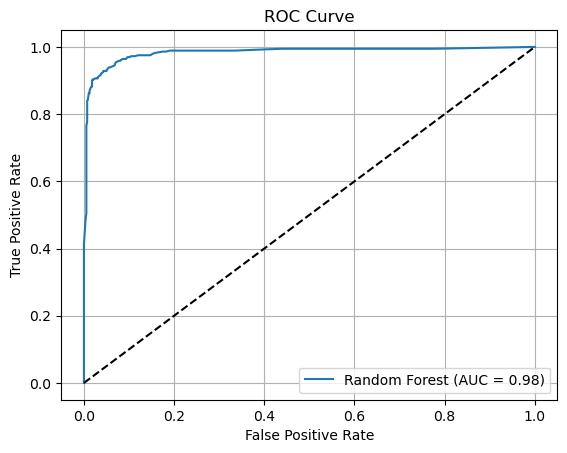

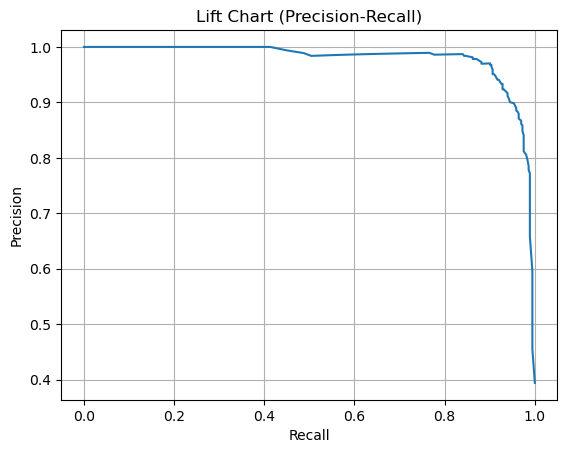

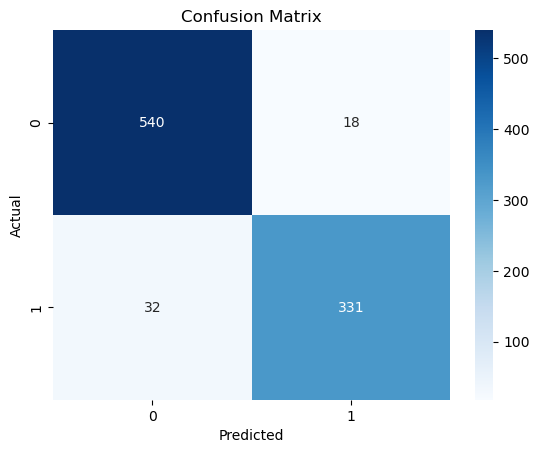

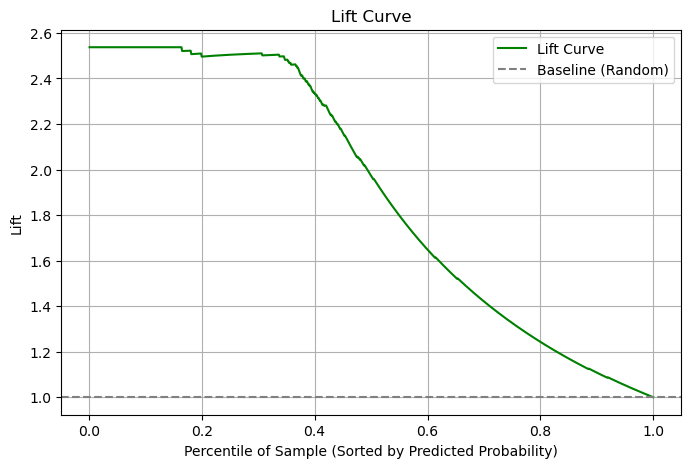

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import seaborn as sns

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{best_cost_model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Lift Chart (PR)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Lift Chart (Precision-Recall)')
plt.grid()
plt.show()

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show

# Sort test instances by predicted probability (descending)
sorted_indices = np.argsort(y_proba)[::-1]
sorted_probs = y_proba[sorted_indices]
sorted_true = np.array(y_test)[sorted_indices]  # convert to array for indexing if needed

# Cumulative true positive rate
cumulative_true_positive_rate = np.cumsum(sorted_true) / np.sum(sorted_true)

# Cumulative percentage of total samples
cumulative_percentile = np.arange(1, len(sorted_true) + 1) / len(sorted_true)

# Lift = how much better we're doing compared to random selection
lift = cumulative_true_positive_rate / cumulative_percentile

# Plot the Lift Curve
plt.figure(figsize=(8, 5))
plt.plot(cumulative_percentile, lift, label='Lift Curve', color='green')
plt.axhline(y=1, color='gray', linestyle='--', label='Baseline (Random)')
plt.xlabel('Percentile of Sample (Sorted by Predicted Probability)')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_test, y_pred, target_names=["Not Spam", "Spam"])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.94      0.97      0.96       558
        Spam       0.95      0.91      0.93       363

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.95      0.95      0.95       921



###  Assignment Write-Up Summary

---

###  Objective

The goal of this project was to build two classification models for detecting spam emails:

1. A model that performs best in terms of **overall predictive accuracy**.
2. A model that performs best in terms of **cost-sensitive classification**, where **false negatives are 10× more costly** than false positives.

---

###  Dataset Overview

- **Dataset**: UCI Spambase
- **Total Records**: 4601 emails
- **Features**: 57 input variables  
- **Target**: Binary (`spam = 1`, `not spam = 0`)
- **Class Distribution**:
  - Class 0 (Not Spam): 2788 samples (60.60%)
  - Class 1 (Spam): 1813 samples (39.40%)
- **Preprocessing**: SMOTE oversampling was applied to address class imbalance when needed.

---

###  Task A: Best Model Based on Accuracy

- **Models Evaluated**: kNN, Decision Tree, Logistic Regression, SVM, Random Forest, Neural Network
- **Evaluation Method**: 5-fold Nested Cross-Validation
- **Best Model**:  Random Forest
- **Nested CV Accuracy**: **0.9516**
- **Test Accuracy**: ~0.948
- **Performance**:
  - Precision and Recall for both classes ≈ **0.95**
  - AUC: **0.9853**

---

###  Task B: Best Model Based on Misclassification Cost

- **Cost Ratio**: False Negative = 10, False Positive = 1
- **Same models tested using average misclassification cost as evaluation metric**
- **Best Model**:  Random Forest
- **Lowest Avg Misclassification Cost**: **0.3125**
- **Test Accuracy**: ~0.951
- **AUC**: **0.9853**
- **F1-score for both classes**: ~**0.94–0.96**

---

###  Hyperparameters for the Selected Model: Random Forest

#### Task A: Accuracy-Based Classification
- `n_estimators`: 100  
- `max_depth`: 10  
(Ensures performance stability and generalization)

#### Task B: Cost-Sensitive Classification
- `n_estimators`: 50  
- `max_depth`: 10  
(Fewer trees to reduce overfitting while maintaining cost-effectiveness)

Hyperparameters were tuned using nested CV for robust model selection.

---

###  Conclusion

The **Random Forest** classifier was the top performer across both tasks:

- Delivered the **highest accuracy**, **AUC**, and **F1-scores**
- Achieved the **lowest misclassification cost** under cost-sensitive settings

Random Forest offered the best trade-off between **precision**, **recall**, and **real-world cost**, making it the most effective and reliable model for spam detection.